In [2]:
if (!require(survRM2)) install.packages('survRM2')
library('survRM2') 
if (!require(mvtnorm)) install.packages('mvtnorm')
library('mvtnorm')
if (!require(survival)) install.packages('survival')
library('survival')
if (!require(nph)) install.packages('nph')
library('nph')
if (!require(foreach)) install.packages("foreach")
library('foreach') 
if (!require(doParallel)) install.packages("doParallel")
library('doParallel')
if (!require(ggplot2)) install.packages("ggplot2")
library('ggplot2')
if (!require(cowplot)) install.packages("cowplot")
library('cowplot')

n_cores <- detectCores()
cluster <- makeCluster(16) # How many cores we use
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster, #import packages to parallel 
  {
  library('survRM2')
  library('mvtnorm')
  library('survival')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('/home/r27user6/RMST_Code/Function.R')
clusterExport(cluster, "expo_gen_2stages")


## Theoretical RMST ($\tau = 1$). No censoring

In [5]:
acc_time <- 1.67
cen_time <- 1
lambda_H0 <- 1.609
lambda_H1 <- 0.916

RMST_RSDST(lambda = lambda_H0, tau = 1)   # detail in Function file
RMST_RSDST(lambda = lambda_H1, tau = 1)

RMST,RSDST
<dbl>,<dbl>
0.4971488,0.1220925


RMST,RSDST
<dbl>,<dbl>
0.6548949,0.1273978


### RMST Estimation with censoring in interim 1 year

RMST of Control arm is: 0.3130104 
Variance of RMST estimation of Control arm is: 1.382051e-05 
RMST of Experiment arm is: 0.3769386 
Variance of RMST estimation of Experiment arm is: 1.697566e-05

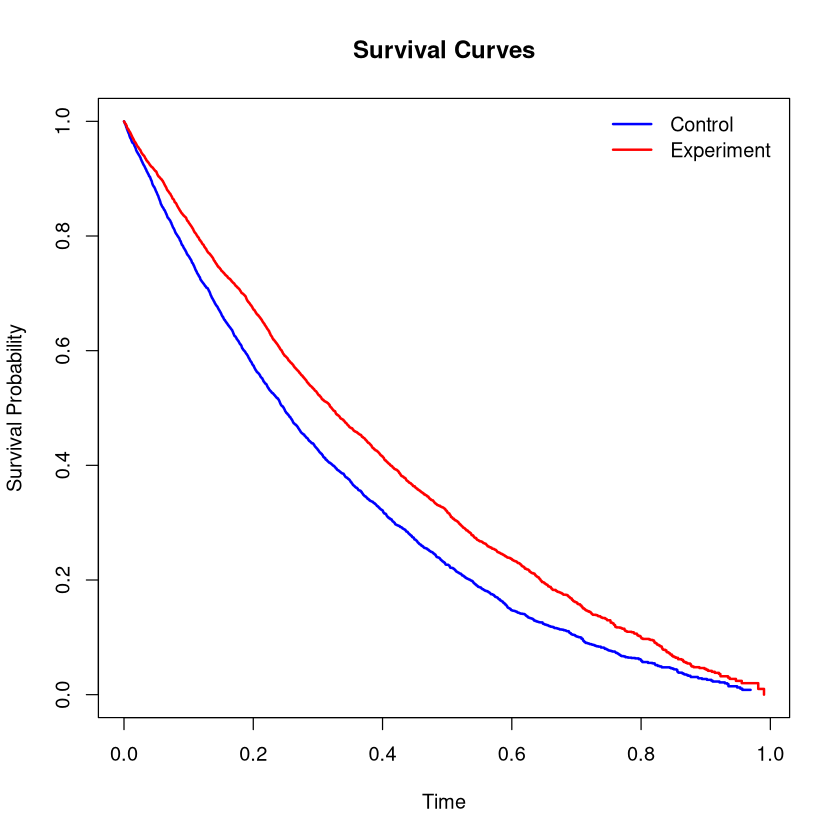

In [5]:
set.seed(2024)
data_C <- expo_gen_2stages(N = 10000, acc_time = acc_time, lambda = lambda_H0, 
                           dist = 'exp', cen_time = cen_time, arm = 0, interim = 1)[ , c(2,3,1)]
data_E <- expo_gen_2stages(N = 10000 ,acc_time = acc_time, lambda = lambda_H1, 
                           dist = 'exp', cen_time = cen_time, arm = 1, interim = 1)[ , c(2,3,1)]
pre_data <- rbind(data_C,data_E)
rmst_result_int <- rmst2(pre_data[,1], pre_data[,2], pre_data[,3],tau = 0.96)

cat('RMST of Control arm is:',rmst_result_int$RMST.arm0$rmst[1],'\n')
cat('Variance of RMST estimation of Control arm is:',rmst_result_int$RMST.arm0$rmst.var,'\n')
cat('RMST of Experiment arm is:',rmst_result_int$RMST.arm1$rmst[1],'\n')
cat('Variance of RMST estimation of Experiment arm is:',rmst_result_int$RMST.arm1$rmst.var)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

### RMST Estimation with censoring in the whole study

RMST of Control arm is: 0.4078671 
Variance of RMST estimation of Control arm is: 1.113824e-05 
RMST of Experiment arm is: 0.5360892 
Variance of RMST estimation of Experiment arm is: 1.372996e-05

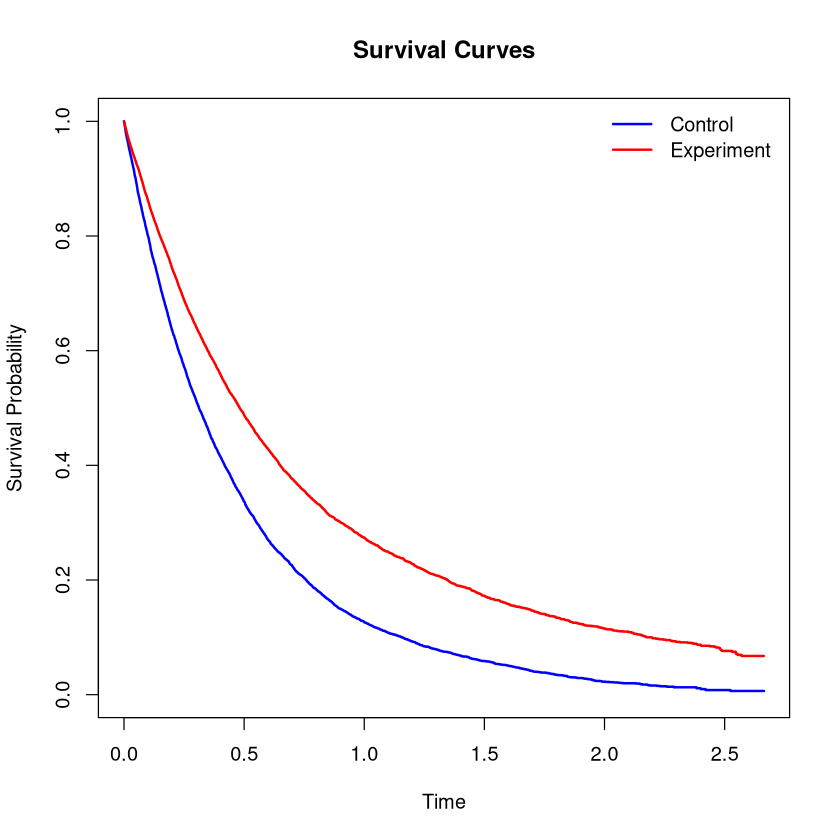

In [6]:
set.seed(2024)
data_C <- expo_gen_2stages(N = 10000, acc_time = acc_time, lambda = lambda_H0, 
                           dist = 'exp', cen_time = cen_time, arm = 0, interim = 1)[ , c(4,5,1)]
data_E <- expo_gen_2stages(N = 10000 ,acc_time = acc_time, lambda = lambda_H1, 
                           dist = 'exp', cen_time = cen_time, arm = 1, interim = 1)[ , c(4,5,1)]
pre_data <- rbind(data_C,data_E)
rmst_result_all <- rmst2(pre_data[,1], pre_data[,2], pre_data[,3],tau = 1)

cat('RMST of Control arm is:',rmst_result_all$RMST.arm0$rmst[1],'\n')
cat('Variance of RMST estimation of Control arm is:',rmst_result_all$RMST.arm0$rmst.var,'\n')
cat('RMST of Experiment arm is:',rmst_result_all$RMST.arm1$rmst[1],'\n')
cat('Variance of RMST estimation of Experiment arm is:',rmst_result_all$RMST.arm1$rmst.var)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

# Prob of Early Termination by Normal integral:

### Use the normality of RMST to calculate the Prob of Early terminaton
####  $\textcolor{lightgreen}{P(E(\tau_1) - C(\tau_1) > m1\ \&\  E(\tau_1) > t1\ |H_0)}$
#### $(E-C,E)$ is bivariate normal. $E$ and $C$ are independent.
#### The covariance matrix $\Sigma$ of $(E-C, E)$ can be easily obtained
#### We set $m_1 = 0, t_1 = 0.3$ here 

In [7]:
mu_c <- rmst_result_int$RMST.arm0$rmst[1]
mu_e <- rmst_result_int$RMST.arm1$rmst[1]
var_c <- rmst_result_int$RMST.arm0$rmst.var
var_e <- rmst_result_int$RMST.arm1$rmst.var

mu_h0 <- c(0, mu_c)
sigma_h0 <- matrix(c(2*var_c, var_c, var_c, var_c), nrow = 2)
mu_h1 <- c(mu_e-mu_c, mu_e)
sigma_h1 <- matrix(c(var_e+var_c, var_e, var_e, var_c), nrow = 2)
upper <- c(Inf, Inf)

lower <- c(-0,0.3)
p_rj_h0 <- 1 - pmvnorm(lower, upper, mean = mu_h0, sigma = sigma_h0) # p(E-C>m1 & E>t1|H0)
p_rj_h1 <- 1 - pmvnorm(lower, upper, mean = mu_h1, sigma = sigma_h1)
cat(' PET0 =',p_rj_h0,'\n','PET1 =',p_rj_h1)

 PET0 = 0.5 
 PET1 = 0

### 10000 simulation (Same setting as Jung 2017)

In [8]:
sim_size <- 10000 
acc_time <- 1.67
cen_time <- 1
lambda_H0 <- 1.609
lambda_H1 <- 0.916
set.seed(2024)
n1 <- 31 
m1 <- 0
t1 <- 0.3

# Use the data in interim period
data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                         cen_time = cen_time,arm = 0, interim = interim)
                        
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                        cen_time = cen_time,arm = 1, interim = interim)
                           
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                         cen_time = cen_time,arm = 1, interim = interim)
                             
rmst_h0 <- RMST_sim_cal(n = n1,data_E = data_E_H0[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                        tau = 2,sim_size = sim_size)
rmst_h1 <- RMST_sim_cal(n = n1,data_E = data_E_H1[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                        tau = 2,sim_size = sim_size)

proc_h0 <- sum((rmst_h0[2, ] - rmst_h0[1, ] > m1) & (rmst_h0[2, ] > t1))
proc_h1 <- sum((rmst_h1[2, ] - rmst_h1[1, ] > m1) & (rmst_h1[2, ] > t1))

cat(' Empirical PET0 =', 1-proc_h0/sim_size,'\n', 'Empirical PET1 = ',1-proc_h1/sim_size)

 Empirical PET0 = 0.65 
 Empirical PET1 =  0.3473

### <font color=LightSeaGreen>The simulated value vary from the theoratical normal calculation.
### The censoring may affact the normality of RMST?

------

# 2 stages Experiment

#### Setting: acc_time = 1.67, cen_time = 1, interim $\tau_1 = 1$
####  $\textcolor{lightgreen}{H_0 : \lambda_0 = \lambda_1 = 1.609}$    
####  $\textcolor{lightgreen}{H_1 : \lambda_0 = 1.609,\ \lambda_1 = 0.916}$  
#### α = 0.1, power = 0.9. Sample size = 102 (51 per arm)   
#### censoring dist in interim: $\tilde{C_i} \sim U[0,\tau_1]$.  After interim: $C_i \sim U[b=1,a+b=2.67]$

### <span style="color:yellow"> find_m_t_RMST is a self-defined function loop to find best m1, m2, t1, t2 in a certain dataset

In [3]:
sim_size <- 10000 
acc_time <- 1.67
cen_time <- 1
lambda_H0 <- 1.609
lambda_H1 <- 0.916
interim <- 1
set.seed(2024)
n <- 51 

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)                             

data_C_int <- data_C[ , c(2,3,1)]  # In the order of (obs_time, event, arm) for RMST test
data_E_H0_int <- data_E_H0[ , c(2,3,1)]
data_E_H1_int <- data_E_H1[ , c(2,3,1)]
rmst_h0_int <- RMST_sim_cal(n = n,data_E = data_E_H0_int, data_C = data_C_int,tau = interim,sim_size = sim_size)
rmst_h1_int <- RMST_sim_cal(n = n,data_E = data_E_H1_int, data_C = data_C_int,tau = interim,sim_size = sim_size)

data_C_fin <- data_C[ , c(4,5,1)]
data_E_H0_fin <- data_E_H0[ , c(4,5,1)]
data_E_H1_fin <- data_E_H1[ , c(4,5,1)]
rmst_h0_fin <- RMST_sim_cal(n = n,data_E = data_E_H0_fin, data_C = data_C_fin,tau = 2,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n,data_E = data_E_H1_fin, data_C = data_C_fin,tau = 2,sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)
rmst_data

,result.1,result.2,result.3,result.4,result.5,result.6,result.7,result.8,result.9,result.10,⋯,result.9991,result.9992,result.9993,result.9994,result.9995,result.9996,result.9997,result.9998,result.9999,result.10000
Est.,0.3248818,0.2843098,0.2748308,0.3041351,0.3537049,0.3109357,0.2734554,0.2402213,0.3061308,0.2652005,⋯,0.2511282,0.3324390,0.3065709,0.3776806,0.2878966,0.2664123,0.2740848,0.3439131,0.2490611,0.2598528
Est.,0.3552232,0.2426718,0.2213753,0.3794768,0.2664254,0.2905974,0.3168201,0.3146036,0.3153880,0.2971433,⋯,0.2726433,0.3153241,0.3431139,0.4538391,0.3118841,0.3082689,0.3389987,0.2888171,0.3043184,0.2827862
Est.,0.3248818,0.2843098,0.3151143,0.3041351,0.3537049,0.3037452,0.2734554,0.2402213,0.3067048,0.2652005,⋯,0.2511282,0.3324390,0.2987594,0.3776806,0.2878966,0.2770013,0.2740848,0.3806303,0.2490611,0.2598528
Est.,0.3408911,0.2838658,0.3057548,0.3704391,0.3980347,0.3517000,0.3266095,0.2936341,0.3605073,0.3912203,⋯,0.2440044,0.2758652,0.3403942,0.3736043,0.3579146,0.2721038,0.2606367,0.2734141,0.3187249,0.3572244
Est.,0.4063303,0.5858651,0.4941125,0.5732738,0.4087738,0.4093955,0.3741305,0.3904434,0.3866853,0.4771734,⋯,0.4521516,0.5161464,0.4707065,0.5136184,0.6015996,0.5382234,0.4138502,0.4978544,0.4715490,0.4914096
Est.,0.5635340,0.3791944,0.4871877,0.4509359,0.5718353,0.5750409,0.3632842,0.5888143,0.4327911,0.3536585,⋯,0.4116954,0.5557268,0.4258803,0.5170885,0.5449676,0.6537668,0.5641662,0.5560642,0.5251808,0.3986577
Est.,0.4063303,0.6077739,0.4941125,0.5278107,0.4087738,0.4093955,0.3571694,0.3904434,0.3866853,0.4771734,⋯,0.4805926,0.5161464,0.4707065,0.5136184,0.6010239,0.5382234,0.4151182,0.5182657,0.4985065,0.4914096
Est.,0.6160724,0.5117701,0.6703521,0.8300010,0.8379127,0.6890487,0.6969592,0.5213445,0.8641594,0.7130377,⋯,0.7730595,0.7297697,0.7139410,0.7547107,0.6971649,0.7658654,0.7028523,0.7170355,0.5425046,0.6439384


### Stage I : process to stage II when:  
####  $\textcolor{lightgreen}{E(\tau_1) - C(\tau_1) > m_1\ \&\  E(\tau_1) > t_1}$
#### Search for a suitable $m_1, t_1$ .m1 from -0.5 to 0.5, t1 from 0 to 1

### Stage II:
#### reject $H_1$ when:  
#### $ \textcolor{lightgreen}{E(\tau_1)-C(\tau_1)>m_1\ \&\  E(\tau_1)>t_1\ \&\  E(\tau_2)-C(\tau_2)>m_2\ \&\  E(\tau_2)>t_2}$

### <span style="color:yellow"> Search for the best parameter combination to get as higher power as possible

### <font color=LightSeaGreen>We don't need to set a strict tar_a1(stage I type I error) since it may lose the overall power
### Loosen tar_a1 will lose PET0, but each time we are looking for the most powerful stage I setting.
### Since the overall rejection region contains the stage I rejection region. They both rise 

In [9]:
find_m_t_RMST(m_low = -0.5, t_low = 0, t_up = 1, rmst_data = rmst_data, search_times = 1000, search_step = 0.001,
         tar_a1 = 0.8, tar_pow1_low = 0.2, tar_a2 = 0.1, sim_size = 10000)

m1,t1,PET0,PET1,m2,t2,alpha,Power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.194,0.26,0.2002,0.0271,-0.062,0.572,0.0999,0.8742


### In Jung (2017) p648 : $PET_0 = 0.2\ ,\  PET_1 = 0.41\ ,\ power = 0.9$

-----

## Log rank test for 2 stages to find the best critical value
### <span style="color:yellow"> find_m_logrank is similar to find_m_t_RMST. 

#### During the interim, process to stage II when:
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>m_1}$, where $W_1\ ,\ \sigma_1$ are log rank test statistics and its variance in interim period
#### Reject H1 final stage when:
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>m_1\ \& \ \frac{W}{\sigma}>m_2}$

In [6]:
z_stats_h0_int <- log_rank_sim(data_C = data_C_int, data_E = data_E_H0_int, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$z_stats
z_stats_h1_int <- log_rank_sim(data_C = data_C_int, data_E = data_E_H1_int, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$z_stats
z_stats_h0_fin <- log_rank_sim(data_C = data_C_fin, data_E = data_E_H0_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$z_stats
z_stats_h1_fin <- log_rank_sim(data_C = data_C_fin, data_E = data_E_H1_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$z_stats
logrank_data <- rbind(z_stats_h0_int, z_stats_h1_int, z_stats_h0_fin, z_stats_h1_fin)
logrank_data 

,result.1,result.2,result.3,result.4,result.5,result.6,result.7,result.8,result.9,result.10,⋯,result.9991,result.9992,result.9993,result.9994,result.9995,result.9996,result.9997,result.9998,result.9999,result.10000
z_stats_h0_int,0.25435623,-0.49131509,-1.0951123,0.98548032,-0.8258920,-0.2139865,0.5307642,0.9831512,-0.01403415,0.7231944,⋯,0.59332742,-0.2859116,0.3140662,0.78519865,0.3766007,0.6432681,0.7433527,-0.9032060,0.6251940,0.2845996
z_stats_h1_int,0.08577508,0.08688511,-0.4197782,0.53407895,0.2740270,0.7289010,1.4418775,0.9497922,0.94049877,1.9059632,⋯,0.02018761,-0.7097043,0.6823996,-0.07217395,1.3568089,0.1279881,0.4636285,-1.0340141,0.7492686,1.4109242
z_stats_h0_fin,1.41625181,-2.24119385,-0.2687052,-0.04222096,0.9966327,0.9286822,0.1770226,2.0284803,0.54969526,-1.1964070,⋯,-0.27101015,0.6568245,-0.4150652,-0.32137708,-0.5015762,0.5153209,1.3026032,0.5560296,0.2986444,-0.5666095
z_stats_h1_fin,1.70555333,-1.02559265,1.6482876,2.35506009,3.2192362,1.6075905,3.0225451,1.3049414,3.34737723,1.7952657,⋯,2.21651792,1.6275156,1.7589994,2.20990149,1.0689752,1.3208558,2.4905820,1.6190837,0.7620341,1.4480069


In [17]:
find_m_logrank(m_low = -6, logrank_data = logrank_data, search_times = 5000, search_step = 0.002,
                tar_a1 = 0.9, tar_pow1_low = 0, tar_a2 = 0.1, sim_size = 10000)

m1,PET0,PET1,m2,alpha,Power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-1.306,0.1002,0.017,1.31,0.0999,0.7087


### Conduct a log rank test at the end of the 2 stages trial. Interim $\tau = 1$ year 

In [18]:
# Empirical alpha
log_rank_sim(data_C = data_C_fin, data_E = data_E_H0_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$rejection
# Empirical power
log_rank_sim(data_C = data_C_fin, data_E = data_E_H1_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$rejection                          

[1] 0.1055

[1] 0.7221

### Corresponding one stage log rank test (Interim $\tau = 0$)

In [19]:
data_C_1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time, arm = 0, interim = 0)[ , c(4,5,1)] 
data_E_H0_1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time, arm = 1, interim = 0)[ , c(4,5,1)]
data_E_H1_1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time, arm = 1, interim = 0)[ , c(4,5,1)]

# Empirical alpha
log_rank_sim(data_C = data_C_1, data_E = data_E_H0_1, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$rejection
# Empirical power
log_rank_sim(data_C = data_C_1, data_E = data_E_H1_1, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$rejection 
                            

[1] 0.1001

[1] 0.9105

### <span style="color:yellow"> Under NPH, should 2 stages log rank test be less powerful than one stage?????
### Under PH, we can find a proper critical value to make 2 stages power ~ single stage 

------

# Test for different Interim Period

### Different Interim $\textcolor{yellow}{\tau}$
### 0.083 year is around a month. From 7 months interim to 16 months.

In [27]:
sim_size <- 10000 
acc_time <- 1.67
cen_time <- 1
lambda_H0 <- 1.609
lambda_H1 <- 0.916
set.seed(2024)
n <- 51  # Fix total sample size

diff_interim_result <- foreach(k = 1:10, .combine = 'rbind',.packages = 'foreach') %dopar% {

    interim <- 0.5 + 0.083 * k 
    # Generate new data under each interim since the truncation is different. 
    # Interim sur time and fin sur time are merged in one dataset
    data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)    
    data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
    data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)        

    rmst_h0_int <- RMST_sim_cal(n = n,data_E = data_E_H0[ , c(2,3,1)], 
                                data_C = data_C[ , c(2,3,1)],tau = interim,sim_size = sim_size)
    rmst_h1_int <- RMST_sim_cal(n = n,data_E = data_E_H1[ , c(2,3,1)], 
                                data_C = data_C[ , c(2,3,1)],tau = interim,sim_size = sim_size)
    rmst_h0_fin <- RMST_sim_cal(n = n,data_E = data_E_H0[ , c(4,5,1)], 
                                data_C = data_C[ , c(4,5,1)],tau = 2,sim_size = sim_size)
    rmst_h1_fin <- RMST_sim_cal(n = n,data_E = data_E_H1[ , c(4,5,1)], 
                                data_C = data_C[ , c(4,5,1)],tau = 2,sim_size = sim_size)
    rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

    # Find and record the most m t combination
    result <- find_m_t_RMST(m_low = -2, t_low = 0, t_up = 1, rmst_data = rmst_data, search_times = 500, 
                       search_step = 0.01, tar_a1 = 0.75, tar_pow1_low = 0.2, tar_a2 = 0.1, sim_size = 10000)

    if (is.null(result)) {
        return(data.frame(m1 = NA, t1 = NA, PET0 = NA, PET1 = NA, m2 = NA, t2 = NA,
                         alpha = NA, Power = NA ))
    }
    return(result)
   
}

In [47]:
diff_interim_result$"interim_month" <- 7:16
diff_interim_result

m1,t1,PET0,PET1,m2,t2,alpha,Power,interim(month),interim_month
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
-0.12,0.178,0.2512,0.1164,-0.14,0.612,0.0968,0.8402,7,7
-0.11,0.198,0.2517,0.0918,-0.19,0.604,0.0983,0.8542,8,8
-0.11,0.218,0.2539,0.0767,-0.17,0.594,0.0994,0.8649,9,9
-0.23,0.236,0.2515,0.0609,-0.18,0.586,0.0989,0.8717,10,10
-0.26,0.252,0.2540,0.0462,-0.18,0.578,0.0988,0.8746,11,11
-0.23,0.268,0.2552,0.0388,-0.10,0.568,0.0998,0.8692,12,12
-0.19,0.282,0.2555,0.0299,-0.11,0.560,0.0999,0.8682,13,13
-0.17,0.296,0.2506,0.0267,-0.07,0.556,0.0997,0.8467,14,14
-0.18,0.310,0.2501,0.0179,-0.07,0.546,0.0998,0.8461,15,15


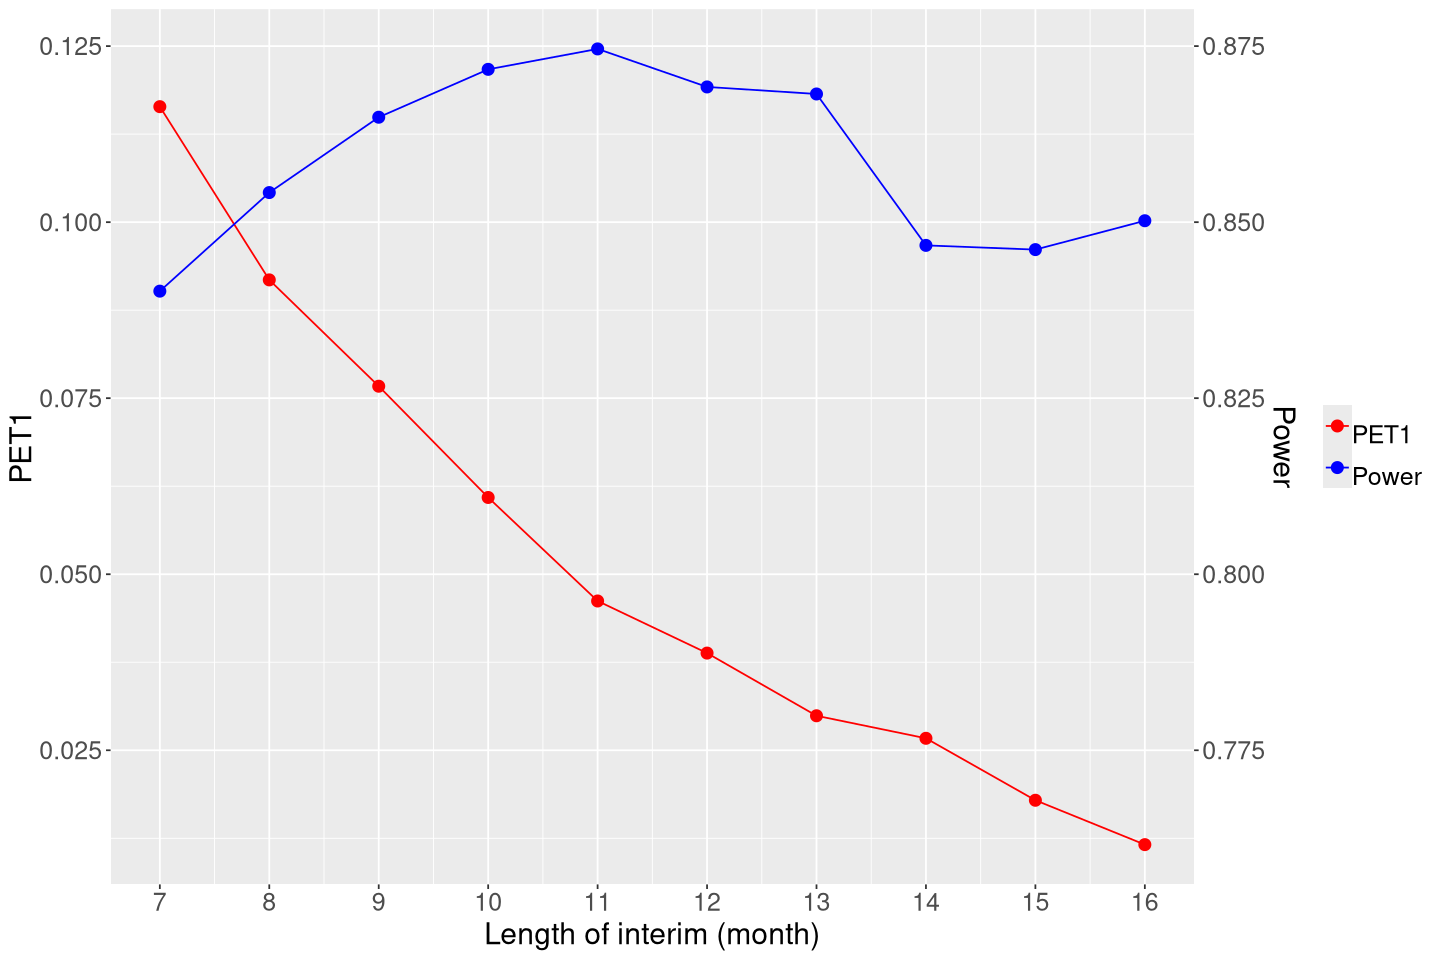

In [62]:
df <- diff_interim_result
options(repr.plot.width = 12, repr.plot.height = 8)

plot_n1 <- ggplot(df) +

  geom_point(data = df, aes(x = interim_month, y = PET1, color = "PET1") ,size = 3) +
  geom_point(data = df, aes(x = interim_month, y = Power - 0.75, color = "Power") ,size = 3) +
  geom_line(data = df, aes(x = interim_month, y = PET1, color = "PET1")) +
  geom_line(data = df, aes(x = interim_month, y = Power - 0.75, color = "Power")) +
  scale_x_continuous(breaks = 7:16 ) +
  scale_y_continuous(name = "PET1", sec.axis = sec_axis(~ . + 0.75, name = "Power")) +
  scale_color_manual("Variable", values = c("PET1" = "red", "Power" = "blue")) +
  theme(legend.title = element_blank(),
         axis.title = element_text(size = 18, margin = margin(t = 20)),
         axis.text = element_text(size = 15,margin = margin(t = 10)),
         legend.text = element_text(size = 15,margin = margin(t = 10))) +
   guides(color = guide_legend(title = "Scales"))+
   labs(x = "Length of interim (month)", y = "PET1")

plot_n1

-------